In [1]:
import duckdb
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px


# run utils.db_setup to set up duckdb database
conn = duckdb.connect('avito.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

There's a new jupysql version available (0.10.12), you're running 0.10.10. To upgrade: pip install jupysql --upgrade
Deploy Streamlit apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


## Schema

<img src="https://relbench.stanford.edu/img/rel-avito.png" alt="schema" width="800"/>

## Tasks

### `ad-ctr`

Regression -- MAE

In [2]:
%%sql train_df <<
from ad_ctr_train;

In [3]:
train_df.head()

,AdID,timestamp,num_click
0,411934,2015-05-04,0.090909
1,424884,2015-04-26,0.020548
2,435123,2015-05-04,0.015267
3,440300,2015-04-26,0.041096
4,440456,2015-04-30,0.166667


In [4]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.AdID.nunique():,} ads.')
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of ads (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='AdID', keep='last')
    .groupby('timestamp').AdID.nunique() / train_df.AdID.nunique()
)
print()
print('Label Distribution:')
mean = train_df.num_click.mean()
std = train_df.num_click.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.num_click == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.num_click.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

5,100 samples over 3,528 ads.

Temporal dist of samples:
timestamp
2015-04    0.60098
2015-05    0.39902
Name: proportion, dtype: float64

Temporal dist of ads (first appearance):
timestamp
2015-04-26    0.285431
2015-04-30    0.277494
2015-05-04    0.437075
Name: AdID, dtype: float64

Label Distribution:
Mean (std): 0.0 ± 0.1
Prop zeros: 0.0%
Quantiles: 
0.0    0.000517
0.1    0.004347
0.2    0.006821
0.3    0.009804
0.4    0.013416
0.5    0.017857
0.6    0.024390
0.7    0.034483
0.8    0.052632
0.9    0.090909
1.0    1.000000
Name: num_click, dtype: float64


In [6]:
%%sql val_df <<
from ad_ctr_val;

In [7]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.AdID.nunique():,} ads.')
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of ads (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='AdID', keep='last')
    .groupby('timestamp').AdID.nunique() / val_df.AdID.nunique()
)
print()
print(f'Ads in val seen in train: {len(set(val_df.AdID) & set(train_df.AdID)):,}')
print()
print('Label Distribution:')
mean = val_df.num_click.mean()
std = val_df.num_click.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.num_click == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.num_click.quantile(np.arange(0, 1.1, 0.1))}')

VAL

1,766 samples over 1,766 ads.

Temporal dist of samples:
timestamp
2015-05    1.0
Name: proportion, dtype: float64

Temporal dist of ads (first appearance):
timestamp
2015-05-08    1.0
Name: AdID, dtype: float64

Ads in val seen in train: 1,027

Label Distribution:
Mean (std): 0.0 ± 0.1
Prop zeros: 0.0%
Quantiles: 
0.0    0.000913
0.1    0.004149
0.2    0.006623
0.3    0.009483
0.4    0.013274
0.5    0.017911
0.6    0.025000
0.7    0.036506
0.8    0.057143
0.9    0.111111
1.0    1.000000
Name: num_click, dtype: float64


### `user-visits`

Binary Classification -- ROCAUC

In [12]:
%%sql train_df <<
select * from user_visits_train;

In [13]:
train_df.head()

,UserID,timestamp,num_click
0,38950,2015-04-26,True
1,35404,2015-04-26,True
2,85455,2015-04-26,True
3,2871,2015-04-26,True
4,34600,2015-04-26,True


In [16]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.UserID.nunique():,} UserIDs.')
print()
print('Label Distribution:')
print(train_df.num_click.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of UserIDs (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='UserID', keep='last')
    .groupby('timestamp').UserID.nunique() / train_df.UserID.nunique()
)

TRAIN

86,619 samples over 44,968 UserIDs.

Label Distribution:
num_click
True     0.905887
False    0.094113
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2015-04    0.625925
2015-05    0.374075
Name: proportion, dtype: float64

Temporal dist of UserIDs (first appearance):
timestamp
2015-04-26    0.348159
2015-04-30    0.274751
2015-05-04    0.377090
Name: UserID, dtype: float64


In [17]:
%%sql val_df <<
select * from user_visits_val;

In [19]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.UserID.nunique():,} UserIDs.')
print()
print('Label Distribution:')
print(val_df.num_click.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'UserIDs in val seen in train: {len(set(val_df.UserID) & set(train_df.UserID)):,}')
print()
print('Temporal dist of UserIDs (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='UserID', keep='last')
    .groupby('timestamp').UserID.nunique() / val_df.UserID.nunique()
)

VAL

29,979 samples over 29,979 UserIDs.

Label Distribution:
num_click
True     0.903499
False    0.096501
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2015-05    1.0
Name: proportion, dtype: float64

UserIDs in val seen in train: 24,343

Temporal dist of UserIDs (first appearance):
timestamp
2015-05-08    1.0
Name: UserID, dtype: float64


### `user-clicks`

In [20]:
%%sql train_df <<
select * from user_clicks_train;

In [21]:
train_df.head()

,UserID,timestamp,num_click
0,69880,2015-04-26,False
1,21033,2015-04-26,False
2,41345,2015-04-26,False
3,26980,2015-04-26,False
4,56394,2015-04-26,False


In [22]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.UserID.nunique():,} UserIDs.')
print()
print('Label Distribution:')
print(train_df.num_click.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of UserIDs (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='UserID', keep='last')
    .groupby('timestamp').UserID.nunique() / train_df.UserID.nunique()
)

TRAIN

59,454 samples over 34,575 UserIDs.

Label Distribution:
num_click
False    0.961281
True     0.038719
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2015-04    0.617974
2015-05    0.382026
Name: proportion, dtype: float64

Temporal dist of UserIDs (first appearance):
timestamp
2015-04-26    0.333449
2015-04-30    0.253015
2015-05-04    0.413536
Name: UserID, dtype: float64


In [23]:
%%sql val_df <<
select * from user_clicks_val;

In [25]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.UserID.nunique():,} UserIDs.')
print()
print('Label Distribution:')
print(val_df.num_click.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'UserIDs in val seen in train: {len(set(val_df.UserID) & set(train_df.UserID)):,}')
print()
print('Temporal dist of UserIDs (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='UserID', keep='last')
    .groupby('timestamp').UserID.nunique() / val_df.UserID.nunique()
)

VAL

21,183 samples over 21,183 UserIDs.

Label Distribution:
num_click
False    0.96483
True     0.03517
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2015-05    1.0
Name: proportion, dtype: float64

UserIDs in val seen in train: 15,562

Temporal dist of UserIDs (first appearance):
timestamp
2015-05-08    1.0
Name: UserID, dtype: float64


## Users

In [26]:
%%sql ads_info <<
select * from AdsInfo;

In [27]:
ads_info

,AdID,LocationID,CategoryID,Price,Title,IsContext
0,0,497.0,22.0,400.0,Босоножки,0.0
1,1,497.0,22.0,6864.0,Tosca Blu Балетки Мотто оригинал,0.0
2,2,335.0,43.0,7800000.0,"Morgan Aero, 2008",0.0
3,3,341.0,47.0,350.0,Доска,0.0
4,4,334.0,14.0,200000.0,MAN TGA 18.480 BLS 2008г,0.0
...,...,...,...,...,...,...
5960553,5960553,375.0,65.0,0.0,Обслуживание,0.0
5960554,5960554,22.0,34.0,0.0,Форточка на бмв,0.0
5960555,5960555,163.0,54.0,20000.0,"2-к квартира, 50 м², 12/14 эт.",0.0
5960556,5960556,5.0,67.0,0.0,Ищу дилера и дистрибьютора,0.0


In [33]:
ads_info.LocationID.value_counts(normalize=True).head(10)

LocationID
497.0    0.156657
334.0    0.096059
136.0    0.024408
495.0    0.024336
331.0    0.022689
440.0    0.020039
38.0     0.018835
36.0     0.018736
376.0    0.018653
175.0    0.018091
Name: proportion, dtype: float64

In [35]:
ads_info.LocationID.isna().value_counts(normalize=True)

LocationID
False    0.995848
True     0.004152
Name: proportion, dtype: float64

In [34]:
ads_info.CategoryID.value_counts(normalize=True).head(10)

CategoryID
43.0    0.124325
34.0    0.111934
22.0    0.089153
38.0    0.059271
60.0    0.052054
47.0    0.050434
50.0    0.041610
54.0    0.041313
42.0    0.040889
41.0    0.035978
Name: proportion, dtype: float64

In [36]:
ads_info.CategoryID.isna().value_counts(normalize=True)

CategoryID
False    0.999995
True     0.000005
Name: proportion, dtype: float64

In [38]:
ads_info.IsContext.value_counts(normalize=True)

IsContext
0.0    0.995849
1.0    0.004151
Name: proportion, dtype: float64

In [41]:
ads_info.Price.describe()

count    5.960495e+06
mean     5.451130e+06
std      1.433890e+09
min      0.000000e+00
25%      7.000000e+02
50%      4.400000e+03
75%      4.000000e+04
max      1.000000e+12
Name: Price, dtype: float64

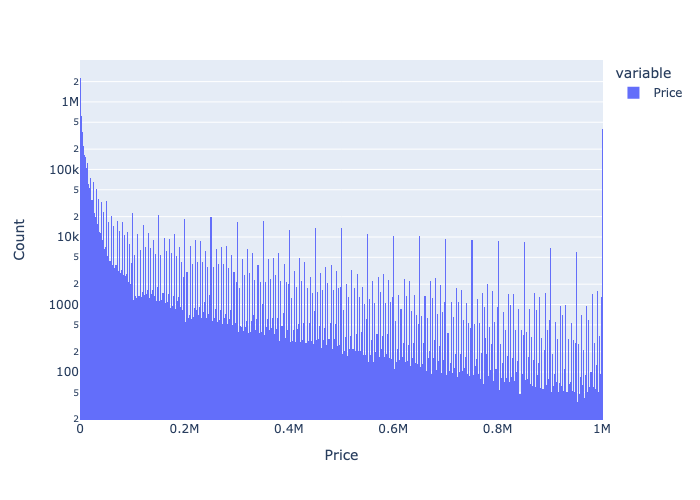

In [46]:
fig = px.histogram(np.clip(ads_info.Price, 1, 1_000_000), log_y=True)
fig.update_layout(width=700, height=500, xaxis_title='Price', yaxis_title='Count')
fig.show(renderer='png')

In [47]:
ads_info.Price.quantile(np.arange(0, 1.1, 0.1))

0.0    0.000000e+00
0.1    1.000000e+02
0.2    5.000000e+02
0.3    1.000000e+03
0.4    2.000000e+03
0.5    4.400000e+03
0.6    9.000000e+03
0.7    2.000000e+04
0.8    1.000000e+05
0.9    5.280000e+05
1.0    1.000000e+12
Name: Price, dtype: float64

## Category

In [48]:
%%sql category <<
select * from Category;

In [49]:
category

,CategoryID,Level,ParentCategoryID,SubcategoryID
0,0,1,10,45
1,1,2,9,45
2,2,3,12,5
3,3,3,9,25
4,4,3,2,39
...,...,...,...,...
63,63,2,11,45
64,64,3,11,33
65,65,3,7,26
66,66,3,11,8


## Location

In [50]:
%%sql location <<
select * from Location;

In [51]:
location

,LocationID,Level,RegionID,CityID
0,0,2.0,70.0,3024.0
1,1,3.0,56.0,2791.0
2,2,3.0,56.0,1139.0
3,3,3.0,64.0,3660.0
4,4,3.0,63.0,1324.0
...,...,...,...,...
3507,3507,3.0,14.0,3414.0
3508,3508,3.0,49.0,2821.0
3509,3509,3.0,14.0,359.0
3510,3510,3.0,36.0,2834.0


## UserInfo

In [52]:
%%sql users <<
select * from UserInfo;

In [53]:
users

,UserID,UserAgentID,UserAgentOSID,UserDeviceID,UserAgentFamilyID
0,0,54898.0,20.0,2014.0,85.0
1,1,15248.0,35.0,4093.0,25.0
2,2,12555.0,30.0,2019.0,9.0
3,3,18624.0,7.0,2014.0,64.0
4,4,44754.0,51.0,3296.0,18.0
...,...,...,...,...,...
98245,98245,27407.0,35.0,135.0,63.0
98246,98246,52045.0,35.0,871.0,62.0
98247,98247,1027.0,20.0,2014.0,7.0
98248,98248,63091.0,20.0,2014.0,25.0


## Event Interest

In [54]:
%%sql phone <<
select * from PhoneRequestsStream;

In [55]:
phone

,UserID,IPID,AdID,PhoneRequestDate
0,38950.0,1629303.0,1938326.0,2015-04-25 11:50:35
1,38950.0,1629303.0,3917327.0,2015-04-25 11:51:14
2,18761.0,109220.0,3806832.0,2015-04-25 12:07:43
3,18761.0,109220.0,573126.0,2015-04-25 12:20:11
4,38950.0,1629303.0,1938326.0,2015-04-25 12:39:22
...,...,...,...,...
244430,NaN,1850902.0,1503766.0,2015-05-13 22:16:59
244431,NaN,1920287.0,NaN,2015-05-13 22:45:32
244432,NaN,1153190.0,NaN,2015-05-13 22:47:11
244433,NaN,2254444.0,NaN,2015-05-13 23:12:37


In [57]:
phone.groupby('UserID')[['AdID', 'IPID']].nunique().describe()

,AdID,IPID
count,30205.000000,30205.0
mean,7.016222,1.0
std,18.356903,0.0
min,1.000000,1.0
25%,1.000000,1.0
50%,3.000000,1.0
75%,7.000000,1.0
max,958.000000,1.0


In [58]:
phone.groupby('AdID')['UserID'].nunique().describe()

count    206748.000000
mean          1.025040
std           0.224643
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          23.000000
Name: UserID, dtype: float64

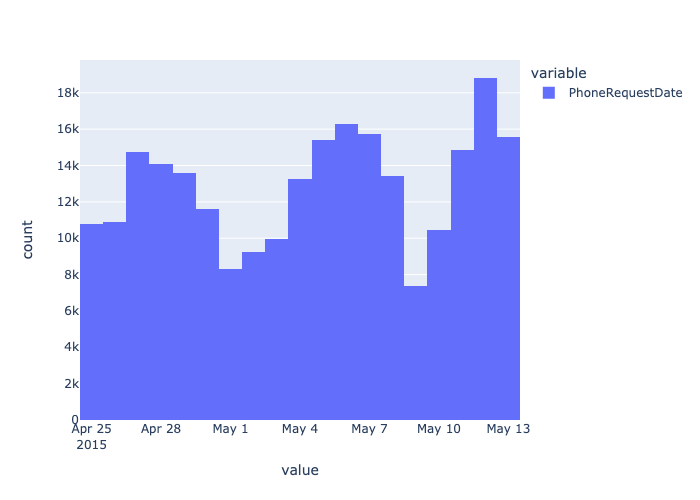

In [74]:
fig = px.histogram(phone['PhoneRequestDate'].dt.strftime('%Y-%m-%d'))
fig.show(renderer='png')

## VisitStream

In [69]:
%%sql visit <<
select * from VisitStream;

In [70]:
visit

,UserID,IPID,AdID,ViewDate
0,20812.0,965680.0,2007763.0,2015-04-25 04:07:16
1,9281.0,76075.0,62087.0,2015-04-25 08:07:31
2,9281.0,76075.0,4459210.0,2015-04-25 08:08:38
3,9281.0,76075.0,3366402.0,2015-04-25 08:12:30
4,9281.0,76075.0,5742539.0,2015-04-25 08:13:01
...,...,...,...,...
5277856,NaN,118228.0,3333694.0,2015-05-13 23:52:32
5277857,NaN,626754.0,NaN,2015-05-13 23:54:42
5277858,NaN,1387203.0,NaN,2015-05-13 23:55:24
5277859,NaN,1797231.0,4012649.0,2015-05-13 23:57:59


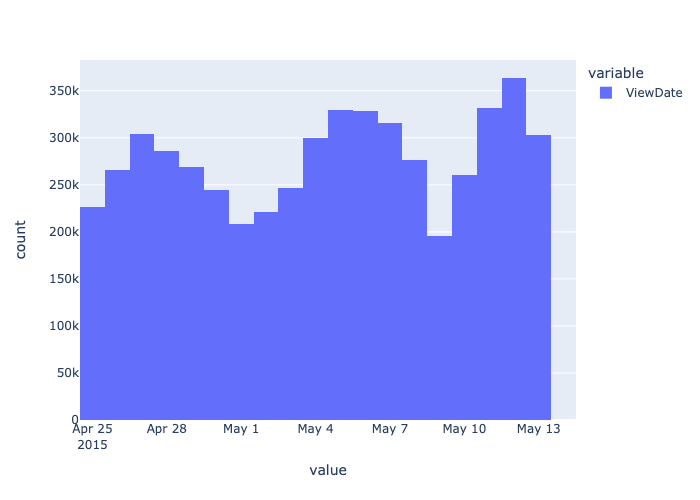

In [76]:
fig = px.histogram(visit['ViewDate'].dt.strftime('%Y-%m-%d'))
fig.show(renderer='png')

In [77]:
visit.groupby('UserID')['AdID'].nunique().describe()

count    58570.000000
mean        70.973912
std        134.877523
min          0.000000
25%          7.000000
50%         25.000000
75%         76.000000
max       3236.000000
Name: AdID, dtype: float64

## SearchStream


In [78]:
%%sql search <<
select * from SearchStream;

In [79]:
search

,SearchID,AdID,Position,ObjectType,HistCTR,IsClick,SearchDate
0,541363.0,806173.0,8.0,1.0,NaN,NaN,2015-04-30 20:57:06
1,541363.0,4316980.0,2.0,1.0,NaN,NaN,2015-04-30 20:57:06
2,541363.0,2059012.0,7.0,1.0,NaN,NaN,2015-04-30 20:57:06
3,541363.0,1586570.0,6.0,1.0,NaN,NaN,2015-04-30 20:57:06
4,541363.0,5827116.0,1.0,3.0,0.005902,0.0,2015-04-30 20:57:06
...,...,...,...,...,...,...,...
7107272,272219.0,2115003.0,7.0,3.0,0.004097,0.0,2015-04-28 05:56:10
7107273,801957.0,2115003.0,7.0,3.0,0.004419,0.0,2015-05-03 21:02:17
7107274,801957.0,4769362.0,1.0,3.0,0.012318,0.0,2015-05-03 21:02:17
7107275,1034975.0,1738506.0,2.0,1.0,NaN,NaN,2015-05-05 21:41:22


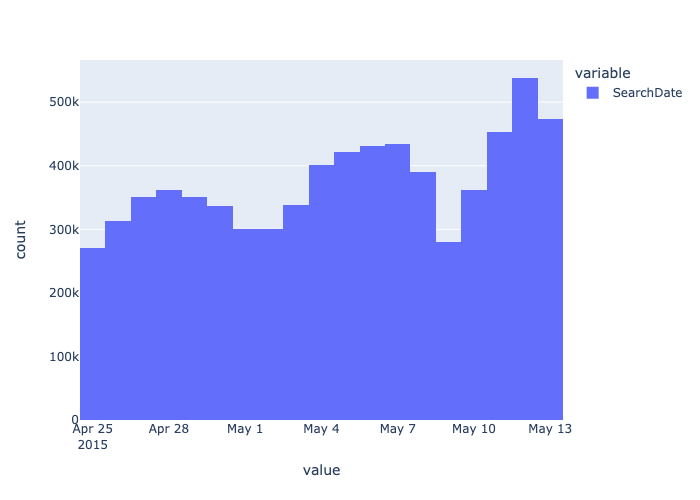

In [80]:
fig = px.histogram(search['SearchDate'].dt.strftime('%Y-%m-%d'))
fig.show(renderer='png')

In [83]:
search.HistCTR.describe()

count    3.433979e+06
mean     1.011698e-02
std      1.529766e-02
min      1.000000e-05
25%      2.300000e-03
50%      5.188000e-03
75%      1.112450e-02
max      1.000000e+00
Name: HistCTR, dtype: float64

In [84]:
search.HistCTR.isna().mean()

0.5168361947902129

In [85]:
search.groupby('SearchID')['AdID'].nunique().describe()

count    1.961887e+06
mean     3.622669e+00
std      1.414210e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      6.000000e+00
Name: AdID, dtype: float64

In [86]:
search.groupby('AdID')['SearchID'].nunique().describe()

count    2.036524e+06
mean     3.489901e+00
std      6.922159e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.377500e+04
Name: SearchID, dtype: float64

## SearchInfo

In [87]:
%%sql info <<
select * from SearchInfo;

In [88]:
info

,UserID,SearchID,SearchDate,IPID,IsUserLoggedOn,SearchQuery,LocationID,CategoryID
0,2139.0,0,2015-04-25 00:00:01,837134.0,1.0,None,497.0,34
1,1477.0,1,2015-04-25 00:00:02,2187370.0,0.0,None,334.0,22
2,68959.0,2,2015-04-25 00:00:02,2089629.0,1.0,None,497.0,60
3,58818.0,3,2015-04-25 00:00:03,63549.0,1.0,sony playstation 4,375.0,0
4,30136.0,4,2015-04-25 00:00:04,1727717.0,0.0,None,334.0,38
...,...,...,...,...,...,...,...,...
1987151,87797.0,1987151,2015-05-13 23:59:51,1065752.0,1.0,None,334.0,60
1987152,66281.0,1987152,2015-05-13 23:59:51,2209435.0,0.0,imac,497.0,17
1987153,97377.0,1987153,2015-05-13 23:59:55,1848828.0,0.0,None,190.0,34
1987154,78797.0,1987154,2015-05-13 23:59:58,684886.0,1.0,None,1.0,26
